In [83]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import gc
from sklearn.linear_model import LinearRegression

# make head display all columns instead of truncting
pd.set_option('display.max_columns', None)

Cases data

In [5]:
# call cases data to jupyter notebook
cases = pd.read_csv("C://Users/schwa/OneDrive/Desktop/School/ECO225/Data/cases.csv")
cases = cases.sort_values("case_name", ascending=True)

### prepare the cases dataset for merging

# create year variable
cases["year_filed"] = cases["case_number"].str.split(":").str[1].str[:2].astype(float)
cases.loc[cases.year_filed > 17, "year_filed"] = cases["year_filed"] + 1900
cases.loc[cases.year_filed < 17, "year_filed"] = cases["year_filed"] + 2000
cases["year_filed"] = cases["year_filed"].fillna(0).astype(float)

# these observations don't have a properly formatted case number
cases = cases.drop(index=[0, 1885, 1886])

# create case order variable (indicates 1 more than the number of cases that the court received before that case in that year)
cases["case_order"] = cases["case_number"].str.split(":").str[1]
cases["case_order"] = cases["case_order"].str.split("-").str[2].astype(float)

# create variable showing the courthouse within the district that received the case
cases["courthouse"] = cases["case_number"].str.split(":").str[0]

# standardize the court name variable so that it can be merged
cases["court_name"] = cases["court_name"].str.title()

# adjust these two specific values
cases["court_name"] = cases["court_name"].str.replace("U.S. District Court (Spokane)", "Eastern District Of Washington")
cases["court_name"] = cases["court_name"].str.replace("U.S. District Court (7)", "7th Court of Appeals")

# create region variable
cases.loc[cases.court_name.str.contains("Eastern"), "court_region"] = "Eastern"
cases.loc[cases.court_name.str.contains("Southern"), "court_region"] = "Southern"
cases.loc[cases.court_name.str.contains("Western"), "court_region"] = "Western"
cases.loc[cases.court_name.str.contains("Northern"), "court_region"] = "Northern"
cases["court_region"] = cases["court_region"].fillna("None")

# create state variable
state_names = ["Alaska", "Alabama", "Arkansas", "American Samoa", "Arizona", "California", "Colorado", "Connecticut", "District Of Columbia", "Delaware", 
          "Florida", "Georgia", "Guam", "Hawaii", "Iowa", "Idaho", "Illinois", "Indiana", "Kansas", "Kentucky", "Louisiana", "Massachusetts", 
          "Maryland", "Maine", "Michigan", "Minnesota", "Missouri", "Mississippi", "Montana", "North Carolina", "North Dakota", "Nebraska", 
          "New Hampshire", "New Jersey", "New Mexico", "Nevada", "New York", "Ohio", "Oklahoma", "Oregon", "Pennsylvania", "Puerto Rico", 
          "Rhode Island", "South Carolina", "South Dakota", "Tennessee", "Texas", "Utah", "Virginia", "Virgin Islands", "Vermont", "Washington", 
          "Wisconsin", "West Virginia", "Wyoming", "7th"]

for state in state_names:
    cases.loc[cases.court_name.str.contains(state), "court_state"] = state

# process demand variable to get rid of non-numeric values
cases["demand"] = cases["demand"].astype(str)
cases.loc[False == cases.demand.str.strip().str.isalpha(), "demand_num"] = cases["demand"]
cases["demand_num"] = cases["demand_num"].str.replace("$", "")
cases["demand_num"] = cases["demand_num"].str.replace(",", "")
cases["demand_num"] = cases["demand_num"].astype(float)

cases.loc[cases.demand.str.strip().str.isalpha(), "demand_party"] = cases["demand"]
cases["demand_party"] = cases["demand_party"].astype(str)
cases["demand_party"] = cases["demand_party"].str.replace("p", "Plaintiff")
cases.loc[cases.demand_party == "P", "demand_party"] = str("Plaintiff")
cases.loc[cases.demand_party == "y", "demand_party"] = np.nan
cases.loc[cases.demand_party == "Y", "demand_party"] = np.nan
cases.loc[cases.demand_party == "nan", "demand_party"] = np.nan
# check you only have the values you desire
cases["demand_party"].unique()

# check for missing values
cases.isna().sum()

case_row_id                 0
case_number                 0
pacer_id                65076
case_name                 198
court_name                  0
assigned_to              2202
referred_to             47699
case_cause               3050
jurisdictional_basis     1897
demand                      0
jury_demand             67675
lead_case               71620
related_case            59695
settlement              74298
date_filed              65119
date_closed             65497
date_last_filed         71614
year_filed                  0
case_order                  0
courthouse                  0
court_region                0
court_state                 0
demand_num              74343
demand_party            23127
dtype: int64

In [6]:
# call pacer_cases data to jupyter notebook
pacer_cases = pd.read_csv("C://Users/schwa/OneDrive/Desktop/School/ECO225/Data/pacer_cases.csv")
pacer_cases = pacer_cases.sort_values("case_name", ascending=True)

# prepare the pacer_cases dataset for merging

# construct year variable
pacer_cases["year_filed"] = pacer_cases["case_number"].str.split(":").str[1].str[:4]
pacer_cases.loc[False == pacer_cases["year_filed"].str.isnumeric(), "year_filed"] = pacer_cases["year_filed"].str[:2].astype(float) + 2000
pacer_cases["year_filed"] = pacer_cases["year_filed"].fillna(0).astype(int)
# NOTE: 0 indicates NaN, 56 values

# construct case order (-1 indicates the number of cases that the court received before that case in that year)
pacer_cases["case_order"] = pacer_cases["case_number"].str.split(":").str[1]
pacer_cases["case_order"] = pacer_cases["case_order"].str.split("-").str[2]
pacer_cases.loc[False == pacer_cases["case_order"].str.isnumeric(), "case_order"] = pacer_cases["case_order"].str.split(".").str[0]
pacer_cases.loc[False == pacer_cases["case_order"].str.isnumeric(), "case_order"] = pacer_cases["case_order"].str[:5]
pacer_cases["case_order"] = pacer_cases["case_order"].astype(float)

# indicates the courthouse within the district that received the case
pacer_cases["courthouse"] = pacer_cases["case_number"].str.split(":").str[0]

# standardize the court name variable so that it can be merged
pacer_cases["court_name"] = pacer_cases["court_name"].str.title()
pacer_cases["court_name"] = pacer_cases["court_name"].str.split("(").str[0]

# create region variable
pacer_cases.loc[pacer_cases.court_name.str.contains("Eastern"), "court_region"] = "Eastern"
pacer_cases.loc[pacer_cases.court_name.str.contains("Southern"), "court_region"] = "Southern"
pacer_cases.loc[pacer_cases.court_name.str.contains("Western"), "court_region"] = "Western"
pacer_cases.loc[pacer_cases.court_name.str.contains("Northern"), "court_region"] = "Northern"
pacer_cases["court_region"] = pacer_cases["court_region"].fillna("None")

# create state variable
state_names = ["Alaska", "Alabama", "Arkansas", "American Samoa", "Arizona", "California", "Colorado", "Connecticut", "District Of Columbia", "Delaware", 
          "Florida", "Georgia", "Guam", "Hawaii", "Iowa", "Idaho", "Illinois", "Indiana", "Kansas", "Kentucky", "Louisiana", "Massachusetts", 
          "Maryland", "Maine", "Michigan", "Minnesota", "Missouri", "Mississippi", "Montana", "North Carolina", "North Dakota", "Nebraska", 
          "New Hampshire", "New Jersey", "New Mexico", "Nevada", "New York", "Ohio", "Oklahoma", "Oregon", "Pennsylvania", "Puerto Rico", 
          "Rhode Island", "South Carolina", "South Dakota", "Tennessee", "Texas", "Utah", "Virginia", "Virgin Islands", "Vermont", "Washington", 
          "Wisconsin", "West Virginia", "Wyoming", "7th"]

for state in state_names:
    pacer_cases.loc[pacer_cases.court_name.str.contains(state), "court_state"] = state

# check for missing values
pacer_cases.isna().sum()
pacer_cases[pacer_cases["case_order"].isna()]
# for 76 rows, the pacer dataset doesn't have a valid case number 

,case_name,court_code,court_name,date_closed,case_number,pacer_id,date_filed,year_filed,case_order,courthouse,court_region,court_state
56071,<b>CASE NUMBER NOT USED</b>,wawd,Washington Western District Court,07/09/2014,<b>CASE NUMBER NOT USED</b>,201976,2014-07-08,0,NaN,<b>CASE NUMBER NOT USED</b>,Western,Washington
38187,<b>DO NOT DOCKET IN THIS CASE - FILE CONSOLIDA...,prd,Puerto Rico District Court,NaN,<b>DO NOT DOCKET IN THIS CASE - FILE CONSOLIDA...,116270,2015-03-25,0,NaN,<b>DO NOT DOCKET IN THIS CASE - FILE CONSOLIDA...,None,Puerto Rico
31710,<font color=red> DO NOT DOCKET. CASE HAS BEEN ...,mnd,Minnesota District Court,03/15/2011,"<font color=""red""> DO NOT DOCKET. CASE HAS BEE...",116638,2010-10-14,0,NaN,"<font color=""red""> DO NOT DOCKET. CASE HAS BEE...",None,Minnesota
57150,<font color=red>**CASE CLOSED-ALL ENTRIES MUST...,mied,Michigan Eastern District Court,10/07/2010,"<font color=""red"">**CASE CLOSED-ALL ENTRIES MU...",246723,2010-02-26,0,NaN,"<font color=""red"">**CASE CLOSED-ALL ENTRIES MU...",Eastern,Michigan
63523,<font color=red>**CASE CLOSED-ALL ENTRIES MUST...,mied,Michigan Eastern District Court,12/24/2013,"<font color=""red"">**CASE CLOSED-ALL ENTRIES MU...",273338,2012-09-11,0,NaN,"<font color=""red"">**CASE CLOSED-ALL ENTRIES MU...",Eastern,Michigan
...,...,...,...,...,...,...,...,...,...,...,...,...
59697,Wacoh Company v. Chrysler LLC et al <font colo...,mied,Michigan Eastern District Court,02/25/2009,"<font color=""red"">**CASE CLOSED - ALL ENTRIES ...",236151,2009-01-12,0,NaN,"<font color=""red"">**CASE CLOSED - ALL ENTRIES ...",Eastern,Michigan
73253,"Walters v. ROSECO, INC. <B><font color=red>Do ...",txsd,Texas Southern District Court,12/05/2011,"<b><font color=""red"">Do Not Docket in 4:11cv15...",882961,2011-04-21,2011,NaN,"<b><font color=""red"">Do Not Docket in 4",Southern,Texas
40269,"WhatRU Holding, LLC v. Bouncing Angels, Inc. e...",mnd,Minnesota District Court,07/01/2014,"<font color=""red"">DO NOT DOCKET. CASE HAS BEEN...",134295,2013-10-04,0,NaN,"<font color=""red"">DO NOT DOCKET. CASE HAS BEEN...",None,Minnesota
65100,"comScore, Inc. v. DoubleVerify Inc.<font color...",vaed,Virginia Eastern District Court,10/28/2013,"<font color=""purple"">DO NOT FILE IN THIS CASE....",283004,2012-07-20,2012,NaN,"<font color=""purple"">DO NOT FILE IN THIS CASE....",Eastern,Virginia


In [7]:
# merge
m_cases = pd.merge(cases, pacer_cases, on=["year_filed", "case_order", "courthouse", "court_region", "court_state"], how="left")

# fill in missing values from the cases dataset using the pacer_cases dataset
m_cases["case_name_x"] = m_cases["case_name_x"].fillna(m_cases["case_name_y"])
m_cases["date_filed_x"] = m_cases["date_filed_x"].fillna(m_cases["date_filed_y"])
m_cases["date_closed_x"] = m_cases["date_closed_x"].fillna(m_cases["date_filed_y"])

# check for missing values
m_cases.isna().sum()

# group dataset by whether the year is before or after 1999
m_cases.loc[m_cases.year_filed >= 1999, "post_99"] = 1
m_cases.loc[m_cases.year_filed < 1999, "post_99"] = 0
grouped_cases = m_cases.groupby(by="post_99")

# convert dates to date format
m_cases["date_filed"] = pd.to_datetime(m_cases["date_filed_x"])
m_cases["date_closed"] = pd.to_datetime(m_cases["date_closed_x"])
m_cases["date_last_filed"] = pd.to_datetime(m_cases["date_last_filed"])

# drop superfluous variables
m_cases = m_cases.drop(columns=["date_filed_x", "date_closed_x", "case_name_y", "court_name_y", "date_closed_y", "case_number_y", 
                                "pacer_id_y", "date_filed_y"])

cases_99 = m_cases[m_cases.post_99 == 1]

cases_99.head(10)

,case_row_id,case_number_x,pacer_id_x,case_name_x,court_name_x,assigned_to,referred_to,case_cause,jurisdictional_basis,demand,jury_demand,lead_case,related_case,settlement,date_last_filed,year_filed,case_order,courthouse,court_region,court_state,demand_num,demand_party,court_code,post_99,date_filed,date_closed
3,37380,2:08-cv-00374,172940.0,(CONSENT) Enviro Tech Chemical Services Inc v....,United States District Court Eastern District ...,NaN,NaN,NaN,NaN,nan,NaN,NaN,NaN,NaN,NaT,2008.0,374.0,2,Eastern,California,NaN,NaN,caed,1.0,2008-02-20,2009-09-11
4,43130,2:13-cv-01052-KJN,NaN,(CONSENT) Nies v. Shafter Cherry Orchard LP,Eastern District Of California - Live System (...,Magistrate Judge Kendall J. Newman,NaN,35:271 Patent Infringement,Federal Question,Plaintiff,NaN,NaN,NaN,NaN,NaT,2013.0,1052.0,2,Eastern,California,NaN,Plaintiff,caed,1.0,2013-05-29,2013-05-29
5,36267,2:06-mc-00047,149149.0,(JFM) Commissariat a L'Energie Atomique v. Sam...,United States District Court Eastern District ...,Senior Judge Lawrence K. Karlton,Magistrate Judge Peter A. Nowinski,Civil Miscellaneous Case,Federal Question,nan,NaN,NaN,NaN,NaN,NaT,2006.0,47.0,2,Eastern,California,NaN,NaN,caed,1.0,2006-04-28,2006-05-31
6,35141,2:05-cv-01503-MCE-PAN,NaN,(JFM) Drake vs. Smith,Eastern District Of California - Live System (...,"Chief Judge Morrison C. England, Jr",Magistrate Judge Peter A. Nowinski,28:1338 Patent Infringement,Federal Question,Plaintiff,NaN,NaN,NaN,NaN,NaT,2005.0,1503.0,2,Eastern,California,NaN,Plaintiff,caed,1.0,2005-07-27,2005-07-27
7,33550,2:03-cv-01842-DFL-KJM,NaN,(PS) Diversified Products v. Blueline Technolo...,Eastern District Of California - Live System (...,Judge David F. Levi,"Magistrate Judge Kimberly J. Mueller, MJ",35:145 Patent Infringement,Federal Question,Both,NaN,NaN,NaN,NaN,NaT,2003.0,1842.0,2,Eastern,California,NaN,Both,caed,1.0,2003-09-05,2003-09-05
8,35542,2:06-cv-00092-FCD-JFM,NaN,(PS) Recht et al v. USA,Eastern District Of California - Live System (...,"Judge Frank C. Damrell, Jr",Magistrate Judge John F. Moulds,28:1331 Fed. Question,U.S. Government Defendant,nan,NaN,NaN,NaN,NaN,NaT,2006.0,92.0,2,Eastern,California,NaN,NaN,caed,1.0,2006-01-27,2006-01-27
9,45017,2:14-cv-02234-GEB-CMK,NaN,"(PS) Stiles v. Wal-Mart Stores Inc, et al",Eastern District Of California - Live System (...,"Judge Garland E. Burrell, Jr",Magistrate Judge Craig M. Kellison,35:145 Patent Infringement,Federal Question,Plaintiff,NaN,NaN,NaN,NaN,NaT,2014.0,2234.0,2,Eastern,California,NaN,Plaintiff,caed,1.0,2014-09-26,2014-09-26
10,38304,2:09-cv-02035-MCE-DAD,NaN,(PS) Van Noland et al v. Pelletier et al,Eastern District Of California - Live System (...,"Chief Judge Morrison C. England, Jr",Magistrate Judge Dale A. Drozd,28:1331 Fed. Question,Federal Question,nan,NaN,NaN,"Nevada County Superior Court, L74759",NaN,NaT,2009.0,2035.0,2,Eastern,California,NaN,NaN,caed,1.0,2009-07-22,2009-07-22
11,24902,1:14-cv-01744-JLT,NaN,(SS) Garcia v. Commissioner of Social Security,Eastern District Of California - Live System (...,Magistrate Judge Jennifer L. Thurston,NaN,42:205 Denial Social Security Benefits,U.S. Government Defendant,nan,NaN,NaN,NaN,NaN,NaT,2014.0,1744.0,1,Eastern,California,NaN,NaN,caed,1.0,2014-11-07,2014-11-07
13,45016,2:14-cv-02227-KJM-AC,NaN,"(TEMP) Sheehan Genetics, et al v. Jakov P. Dul...",Eastern District Of California - Live System (...,District Judge Kimberly J. Mueller,Magistrate Judge Allison Claire,28:2201 Declaratory Judgement,Federal Question,Both,NaN,NaN,NaN,NaN,NaT,2014.0,2227.0,2,Eastern,California,NaN,Both,caed,1.0,2014-09-25,2014-09-25


Attorneys Data

In [9]:
# call data to jupyter notebook
attorneys = pd.read_csv("C://Users/schwa/OneDrive/Desktop/School/ECO225/Data/attorneys.csv")
gender = pd.read_csv("C://Users/schwa/OneDrive/Desktop/School/ECO225/Data/wgnd_2_0_name-gender_nocode.csv")

# drop superfluous variables
attorneys = attorneys.drop(["contactinfo"], axis = 1)

# collapse dataset so that there's only one entry per attorney per case
attorneys = attorneys.groupby(["case_row_id", "name"]).agg("first")
attorneys = attorneys.reset_index()

# create variable w first name
attorneys["first_name"] = attorneys["name"].str.split().str[0].str.lower().astype(str)

# merge with gender dataset, drop the dataset
attorneys = attorneys.merge(gender, left_on="first_name", right_on="name", how="left")
del [gender]
gc.collect()
gender = pd.DataFrame()

attorneys
attorneys.isna().sum()

case_row_id               0
name_x                    0
case_number               0
party_row_count           0
party_type                0
attorney_row_count        0
position              14451
first_name                0
name_y                31089
gender                31089
dtype: int64

In [10]:
missing_attorneys = attorneys[attorneys["gender"].isna()]
missing_attorneys = missing_attorneys[missing_attorneys["name_x"].isna() == False]

# merge with dataset with gender names for US
gender = pd.read_csv("C://Users/schwa/OneDrive/Desktop/School/ECO225/Data/wgnd_2_0_name-gender-code_US_likely.csv")
missing_attorneys = missing_attorneys.merge(gender, left_on="first_name", right_on="name",how="left")
missing_attorneys.isna().sum()

# drop variables so you can concat the missing_attorneys dataset with the attorneys dataset
missing_attorneys["name_y"] = missing_attorneys["name"]
missing_attorneys["gender"] = missing_attorneys["gender_y"]
missing_attorneys = missing_attorneys.drop(["name", "gender_y", "gender_x"], axis= 1)

# drop missing values from the attorneys dataset, add back the missing_attorneys
attorneys = attorneys[attorneys["gender"].isna() == False]
attorneys = pd.concat([attorneys, missing_attorneys], axis = 0)
attorneys.isna().sum()

case_row_id               0
name_x                    0
case_number               0
party_row_count           0
party_type                0
attorney_row_count        0
position              14452
first_name                0
name_y                24295
gender                24295
dtype: int64

In [11]:
# use to see the possible values for party type
list(attorneys["party_type"].unique())

['Defendant ',
 'Plaintiff ',
 'ThirdParty Defendant ',
 'Consol Defendant ',
 'Counter Defendant ',
 'Counter Claimant ',
 'Plaintiff',
 'Defendant',
 'Intervenor Plaintiff ',
 'Special Master ',
 'Intervenor ',
 'Intervenor',
 'Special Master',
 'Intervenor Defendant ',
 'Garnishee',
 'Garnishee ',
 'Movant ',
 'Petitioner ',
 'Respondent ',
 'Counter Defendant',
 'Counter Claimant',
 'Objector ',
 'Consol Plaintiff ',
 'Appellant ',
 'In Re ',
 'ThirdParty Defendant',
 'Amicus ',
 'plaintiff ',
 'defendant ',
 'Consolidated Plaintiff ',
 'Mediator ',
 'Third Party Defendant ',
 'movant ',
 'mediator ',
 'deponent ',
 'proposed ',
 '3rd Pty Defendant ',
 'Counter-Claimant ',
 '3rd Party Plaintiff ',
 'Counterclaim Defendant ',
 'Arbitrator ',
 'ThirdParty Plaintiff ',
 'third-party defendant ',
 'objector ',
 'Neutral ',
 'counter-defendant ',
 'Counterclaim Plaintiff ',
 'Consolidated Defendant ',
 'Interested Party ',
 'trustee ',
 'Counter Plaintiff ',
 'ENE Evaluator ',
 'Counter

In [12]:
# label each attorney either defendent, plantiff, garnishee, mediator, witness, or other
list(attorneys["party_type"].unique())
attorneys["party_type"] = attorneys["party_type"].str.lower()

attorneys.loc[attorneys.party_type.str.contains("defendant"), "defendant"] = 1
attorneys.loc[attorneys.party_type.str.contains("respondent"), "defendant"] = 1
attorneys.loc[attorneys.party_type.str.contains("counter claimant"), "defendant"] = 1
attorneys.loc[attorneys.party_type.str.contains("dft"), "defendant"] = 1
attorneys.loc[attorneys.party_type.str.contains("plaintiff"), "plaintiff"] = 1
attorneys.loc[attorneys.party_type.str.contains("mediator"), "mediator"] = 1
attorneys.loc[attorneys.party_type.str.contains("witness"), "witness"] = 1
attorneys.loc[attorneys.party_type.str.contains("deponent"), "witness"] = 1

attorneys.loc[attorneys.defendant.isna(), "other"] = 1
attorneys.loc[attorneys.plaintiff.isna() == False, "other"] = 0
attorneys.loc[attorneys.mediator.isna() == False, "other"] = 0
attorneys.loc[attorneys.witness.isna() == False, "other"] = 0
attorneys.loc[attorneys.position.isna() == False, "other"] = 0

# create gendered variables for each attorney category
attorneys.loc[(attorneys["defendant"] == 1)&(attorneys["gender"] == "M"), "defendant_M"] = 1
attorneys.loc[(attorneys["defendant"] == 1)&(attorneys["gender"] == "F"), "defendant_F"] = 1
attorneys.loc[(attorneys["plaintiff"] == 1)&(attorneys["gender"] == "M"), "plaintiff_M"] = 1
attorneys.loc[(attorneys["plaintiff"] == 1)&(attorneys["gender"] == "F"), "plaintiff_F"] = 1
attorneys.loc[(attorneys["mediator"] == 1)&(attorneys["gender"] == "M"), "mediator_M"] = 1
attorneys.loc[(attorneys["mediator"] == 1)&(attorneys["gender"] == "F"), "mediator_F"] = 1
attorneys.loc[(attorneys["witness"] == 1)&(attorneys["gender"] == "M"), "witness_M"] = 1
attorneys.loc[(attorneys["witness"] == 1)&(attorneys["gender"] == "F"), "witness_F"] = 1
attorneys.loc[(attorneys["other"] == 1)&(attorneys["gender"] == "M"), "other_M"] = 1
attorneys.loc[(attorneys["other"] == 1)&(attorneys["gender"] == "F"), "other_F"] = 1

attorneys.loc[attorneys["gender"] == "M", "male"] = 1
attorneys.loc[attorneys["gender"] == "F", "female"] = 1
attorneys["total"] = 1

attorneys.head(20)

,case_row_id,name_x,case_number,party_row_count,party_type,attorney_row_count,position,first_name,name_y,gender,defendant,plaintiff,mediator,witness,other,defendant_M,defendant_F,plaintiff_M,plaintiff_F,mediator_M,mediator_F,witness_M,witness_F,other_M,other_F,male,female,total
0,14,Edwin Russell Jeter,0:92-cv-00398-MJP,45,defendant,6,LEAD ATTORNEY; ATTORNEY TO BE NOTICED,edwin,edwin,M,1.0,NaN,NaN,NaN,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1
1,14,"Joel Wyman Collins , Jr",0:92-cv-00398-MJP,40,plaintiff,1,LEAD ATTORNEY; ATTORNEY TO BE NOTICED,joel,joel,M,NaN,1.0,NaN,NaN,0.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1
2,14,John Edward Cuttino,0:92-cv-00398-MJP,45,defendant,7,TERMINATED: 03/17/1994; LEAD ATTORNEY; ATTORNE...,john,john,M,1.0,NaN,NaN,NaN,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1
3,14,Paul L Gardner,0:92-cv-00398-MJP,45,defendant,8,LEAD ATTORNEY; ATTORNEY TO BE NOTICED,paul,paul,M,1.0,NaN,NaN,NaN,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1
4,14,R Bentz Kirby,0:92-cv-00398-MJP,45,defendant,9,TERMINATED: 06/05/1992; LEAD ATTORNEY; ATTORNE...,r,r,M,1.0,NaN,NaN,NaN,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1
5,38,Aaron Samuel Podhurst,0:89-cv-06934-NCR,119,defendant,39,LEAD ATTORNEY; ATTORNEY TO BE NOTICED,aaron,aaron,M,1.0,NaN,NaN,NaN,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1
6,38,Arnold A. Pagniucci,0:89-cv-06934-NCR,119,defendant,45,ATTORNEY TO BE NOTICED,arnold,arnold,M,1.0,NaN,NaN,NaN,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1
7,38,Daniel R. Cherry,0:89-cv-06934-NCR,119,defendant,40,LEAD ATTORNEY; ATTORNEY TO BE NOTICED,daniel,daniel,M,1.0,NaN,NaN,NaN,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1
8,38,David Berten,0:89-cv-06934-NCR,118,plaintiff,26,LEAD ATTORNEY; ATTORNEY TO BE NOTICED,david,david,M,NaN,1.0,NaN,NaN,0.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1
9,38,Dennis Alan Richard,0:89-cv-06934-NCR,119,defendant,41,LEAD ATTORNEY; ATTORNEY TO BE NOTICED,dennis,dennis,M,1.0,NaN,NaN,NaN,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1


In [13]:
# aggregate to create one row per case
c_attorneys = attorneys.groupby("case_row_id").agg("sum")

c_attorneys = c_attorneys.fillna(0)
c_attorneys = c_attorneys.drop(c_attorneys.iloc[:, 0:9], axis=1)
c_attorneys.head(10)

,defendant,plaintiff,mediator,witness,other,defendant_M,defendant_F,plaintiff_M,plaintiff_F,mediator_M,mediator_F,witness_M,witness_F,other_M,other_F,male,female,total
case_row_id,,,,,,,,,,,,,,,,,,
14,4.0,1.0,0.0,0.0,0.0,4.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,5
38,9.0,13.0,0.0,0.0,0.0,8.0,1.0,12.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0,2.0,22
39,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,2
40,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,2
41,1.0,2.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,3
43,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,2
45,1.0,4.0,0.0,0.0,0.0,1.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,5
46,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1
47,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1


Documents data

In [170]:
# call data to jupyter notebook
documents = pd.read_csv("C://Users/schwa/OneDrive/Desktop/School/ECO225/Data/documents.csv", low_memory=False)

# clean
documents["number_docs"] = 1
doc_agg = documents.groupby("case_row_id").agg("sum")

doc_agg.head(10)

,case_number,doc_count,attachment,date_filed,long_description,doc_number,short_description,upload_date,number_docs
case_row_id,,,,,,,,,
1,0:79-cv-06704-JCP0:79-cv-06704-JCP,3,0.0,2000-08-031982-05-31,"COPY OF PAPER DOCKET SHEET (kw, Deputy Clerk) ...",37,0,0,2
3,0:83-cv-06860-JAG0:83-cv-06860-JAG0:83-cv-0686...,15,0.0,2004-02-131992-03-011990-10-161987-07-221987-0...,COPY OF PAPER DOCKET SHEET (Former Deputy Cler...,12394,0,0,5
4,0:84-cv-06456-KLR,1,0.0,2004-01-16,COPY OF PAPER DOCKET SHEET (Former Deputy Cler...,123,0,0,1
5,0:84-cv-06726-WMH0:84-cv-06726-WMH0:84-cv-0672...,10,0.0,2003-11-212003-11-211991-03-291991-03-29,COPY OF PAPER DOCKET SHEET (Former Deputy Cler...,3421,0,0,4
6,0:85-cv-06225-TES,1,0.0,2003-10-22,COPY OF PAPER DOCKET SHEET (Former Deputy Cler...,123,0,0,1
7,0:85-cv-06368-JCP,1,0.0,2003-10-10,COPY OF PAPER DOCKET SHEET (Former Deputy Cler...,81,0,0,1
8,0:85-cv-06452-WJZ,1,0.0,2003-10-09,COPY OF PAPER DOCKET SHEET (Former Deputy Cler...,178,0,0,1
9,0:85-cv-06607-JAG,1,0.0,2003-10-06,COPY OF PAPER DOCKET SHEET (Former Deputy Cler...,155,0,0,1
10,0:86-cv-06181-JWK0:86-cv-06181-JWK,3,0.0,2003-08-201986-11-25,COPY OF PAPER DOCKET SHEET (Former Deputy Cler...,17,0,0,2


In [172]:
doc_agg = doc_agg.drop(doc_agg.iloc[:, 0:8], axis=1)
doc_agg

,number_docs
case_row_id,
1,2
3,5
4,1
5,4
6,1
...,...
74669,17
74671,6
74672,22


In [ ]:
# use for code trying to see types of documents
documents.loc[documents['long_description'].str.contains(r"\bsettle\b", na=False, case=False), "settled"] = 1

Names data

In [ ]:
# call data to jupyter notebook
names = pd.read_csv("C://Users/schwa/OneDrive/Desktop/School/ECO225/Data/names.csv").set_index("case_row_id")

# clean

# get summary statistics

Merging

In [174]:
# merge
df = cases_99.merge(c_attorneys, on="case_row_id", how="left")
df = df.merge(doc_agg, on="case_row_id", how="left")
df.isna().sum()
# df.head(20)

case_row_id                 0
case_number_x               0
pacer_id_x              49746
case_name_x                 2
court_name_x                0
assigned_to              1674
referred_to             35319
case_cause               1772
jurisdictional_basis     1500
demand                      0
jury_demand             51868
lead_case               55832
related_case            46279
settlement              58372
date_last_filed         56037
year_filed                  0
case_order                  0
courthouse                  0
court_region                0
court_state                 0
demand_num              58585
demand_party            16317
court_code               5737
post_99                     0
date_filed               5730
date_closed              5731
defendant                2079
plaintiff                2079
mediator                 2079
witness                  2079
other                    2079
defendant_M              2079
defendant_F              2079
plaintiff_

Creating summary statistics and figures

        year_filed                                                         \
             count         mean       std     min     25%     50%     75%   
post_99                                                                     
0.0        15996.0  1993.659352  3.557985  1963.0  1991.0  1994.0  1997.0   
1.0        58642.0  2008.568432  4.950129  1999.0  2004.0  2010.0  2013.0   

                demand_num                                                   \
            max      count          mean            std  min  25%  50%  75%   
post_99                                                                       
0.0      1998.0      226.0  77969.026549  751884.532457  0.0  0.0  0.0  0.0   
1.0      2015.0       57.0   8771.929825   66226.617853  0.0  0.0  0.0  0.0   

                    
               max  
post_99             
0.0      9999000.0  
1.0       500000.0  
post_99  jury_demand
0.0      Plaintiff        90
         Both             66
         Defendant        22
1.0  

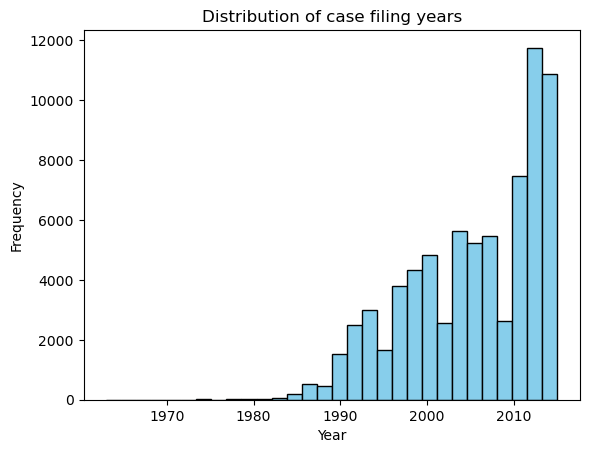

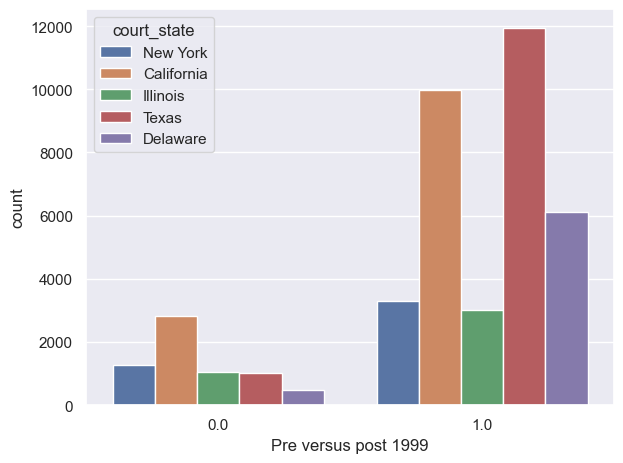

In [25]:
### figures/summary stats for understanding the dataset

# general summary statistics for numeric variables
summary_numeric = grouped_cases[["year_filed", "demand_num"]].describe()
print(summary_numeric)

# create crosstab of jury demand
freq_jury = grouped_cases["jury_demand"].value_counts()
print(freq_jury)
                        
# create a histogram of filing over time
plt.hist(m_cases["year_filed"], bins=30, color='skyblue', edgecolor='black')
# Adding labels and title
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.title('Distribution of case filing years') 
# Display the plot
plt.show()

# create a bar chart of the distribution of cases across year by most filed in states
most_filed_states_id = m_cases["court_state"].value_counts().nlargest(5).index
most_filed_states = m_cases.loc[m_cases["court_state"].isin(most_filed_states_id), :]
list(most_filed_states["court_state"].unique())
sns.set()
ax = sns.countplot(data=most_filed_states, x='post_99', hue='court_state')
ax.set_xlabel('Pre versus post 1999') 
plt.tight_layout()
plt.show()

In [196]:
df.describe()

,case_row_id,pacer_id_x,date_last_filed,year_filed,case_order,demand_num,post_99,date_filed,date_closed,defendant,plaintiff,mediator,witness,other,defendant_M,defendant_F,plaintiff_M,plaintiff_F,mediator_M,mediator_F,witness_M,witness_F,other_M,other_F,male,female,total,number_docs
count,58642.000000,8.896000e+03,2605,58642.000000,58642.000000,57.000000,58642.0,52912,52911,56563.000000,56563.000000,56563.000000,56563.000000,56563.000000,56563.000000,56563.000000,56563.000000,56563.000000,56563.000000,56563.000000,56563.000000,56563.000000,56563.000000,56563.000000,56563.000000,56563.000000,56563.000000,58538.000000
mean,38978.414788,1.688099e+05,2009-06-01 20:10:02.533588992,2008.568432,3826.924849,8771.929825,1.0,2009-03-19 16:56:53.305110272,2009-06-01 08:41:51.447525120,3.994166,3.376819,0.036950,0.000566,0.010696,3.111009,0.674098,2.740643,0.486537,0.034333,0.000919,0.000442,0.000124,0.008292,0.001202,5.983187,1.181479,7.531001,69.963955
min,337.000000,3.000000e+00,1999-02-01 00:00:00,1999.000000,1.000000,0.000000,1.0,1996-08-29 00:00:00,1996-08-29 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
25%,20475.250000,5.400925e+04,2007-04-11 00:00:00,2004.000000,433.250000,0.000000,1.0,2005-01-19 00:00:00,2005-04-25 00:00:00,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,3.000000,15.000000
50%,39005.500000,1.358985e+05,2009-08-19 00:00:00,2010.000000,1095.000000,0.000000,1.0,2010-06-28 00:00:00,2010-09-21 00:00:00,2.000000,3.000000,0.000000,0.000000,0.000000,2.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,1.000000,5.000000,30.000000
75%,56544.750000,2.357320e+05,2012-08-01 00:00:00,2013.000000,3058.000000,0.000000,1.0,2013-06-17 00:00:00,2013-08-23 00:00:00,5.000000,4.000000,0.000000,0.000000,0.000000,4.000000,1.000000,4.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.000000,2.000000,9.000000,67.000000
max,74674.000000,1.218702e+06,2016-02-29 00:00:00,2015.000000,90703.000000,500000.000000,1.0,2015-12-31 00:00:00,2016-02-12 00:00:00,308.000000,81.000000,4.000000,3.000000,27.000000,234.000000,58.000000,60.000000,24.000000,4.000000,1.000000,3.000000,1.000000,9.000000,2.000000,322.000000,84.000000,423.000000,8461.000000
std,20587.024118,1.464487e+05,NaN,4.950129,10221.635786,66226.617853,0.0,NaN,NaN,7.349850,3.050888,0.204212,0.032017,0.173901,5.801281,1.470550,2.465358,0.876204,0.194662,0.030307,0.026920,0.011124,0.117515,0.035159,7.239896,1.922052,9.179689,129.712680


Text(0.5, 1.0, 'Distribution of documents filed per US patent case, 1999-2015')

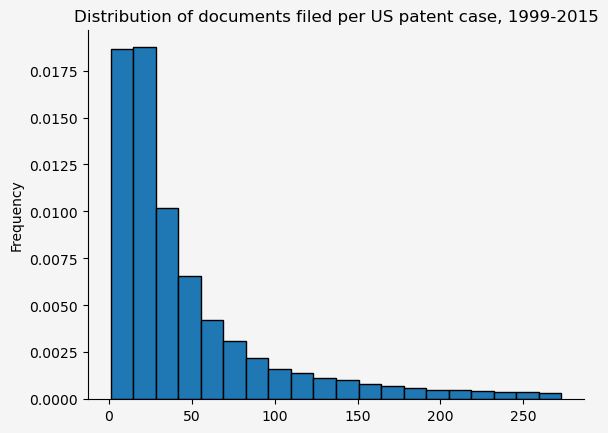

In [214]:
# histogram of the number of documents filed per case
df_hist = df[df["number_docs"] < df["number_docs"].quantile(0.95)]

fig, ax = plt.subplots()
df_hist.plot(
    kind="hist", y="number_docs",
    bins=20, legend=False, density=True, ax=ax, edgecolor = "black"
)
ax.set_facecolor((0.96, 0.96, 0.96))
fig.set_facecolor((0.96, 0.96, 0.96))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_title("Distribution of documents filed per US patent case, 1999-2015")

<Axes: xlabel='year_range'>

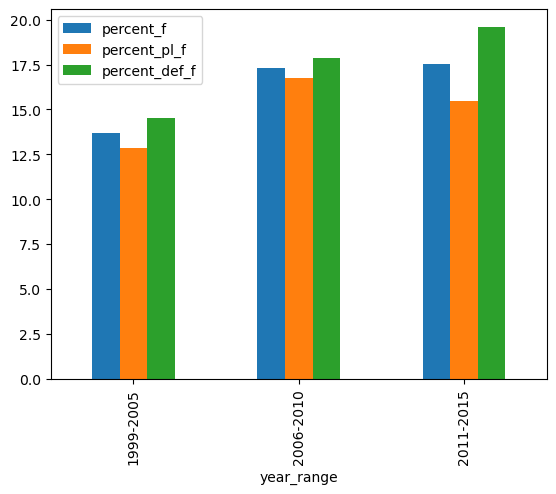

In [59]:
### bar chart of % of lawyers who are women by party type

# collapse dataset over year ranges
df_year = df.drop(df.iloc[:, 0:14], axis=1)
df_year = df_year.drop(["date_filed",	"date_closed", "date_last_filed"], axis=1)
df_year.loc[df_year["year_filed"] <= 2005, "year_range"] = "1999-2005"
df_year.loc[(2006 <= df_year["year_filed"]) & (df_year["year_filed"] <= 2010), "year_range"] = "2006-2010"
df_year.loc[df_year["year_filed"] >= 2011, "year_range"] = "2011-2015"
df_year = df_year.groupby("year_range").agg("sum")
df_year = df_year.reset_index()

# create variables with proportion of female attorneys for each party type
df_year["percent_f"] = 100 * df_year["female"] / (df_year["female"] + df_year["male"])
df_year["percent_pl_f"] = 100 * df_year["plaintiff_F"] / (df_year["plaintiff_F"] + df_year["plaintiff_M"])
df_year["percent_def_f"] = 100 * df_year["defendant_F"] / (df_year["defendant_F"] + df_year["defendant_M"])
# df_year["percent_med_f"] = 100 * df_year["mediator_F"] / (df_year["mediator_F"] + df_year["mediator_M"])
# df_year["percent_wit_f"] = 100 * df_year["witness_F"] / (df_year["witness_F"] + df_year["witness_M"])
# df_year["percent_other_f"] = 100 * df_year["other_F"] / (df_year["other_F"] + df_year["other_M"])

df_year = df_year.drop(df_year.iloc[:, 1:28], axis=1)

# df_year.plot(x="year_range", kind="bar", stacked=False)

In [61]:
Row_list =[]

# iterate over each row
for index, rows in df_year.iterrows():
    # Create list for the current row
    my_list =[rows.percent_f, rows.percent_def_f, rows.percent_pl_f]
    
    # append the list to the final list
    Row_list.append(my_list)

print(Row_list)
df_year

[[13.693342431036163, 14.509728745327326, 12.827724967663785], [17.309679641749913, 17.85009129911967, 16.727929181982294], [17.518561205071162, 19.600088822154785, 15.458425815263787]]


,year_range,percent_f,percent_pl_f,percent_def_f
0,1999-2005,13.693342,12.827725,14.509729
1,2006-2010,17.309680,16.727929,17.850091
2,2011-2015,17.518561,15.458426,19.600089


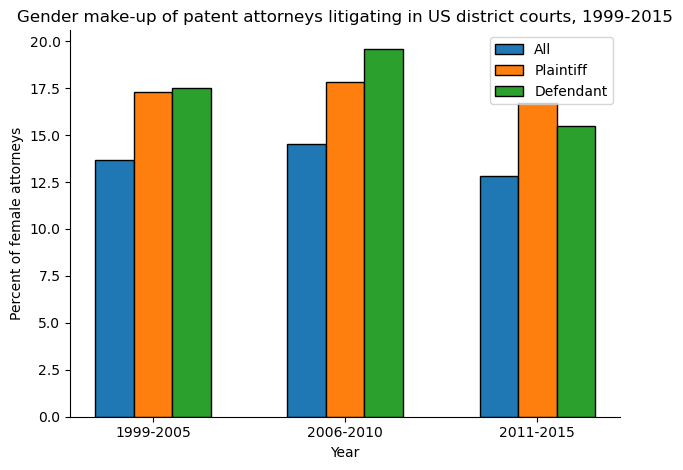

In [218]:
labels = ["All", "Plaintiff", "Defendant"]

Row_list =[]

# iterate over each row
for index, rows in df_year.iterrows():
    # Create list for the current row
    my_list =[rows.percent_f, rows.percent_def_f, rows.percent_pl_f]
    # append the list to the final list
    Row_list.append(my_list)

range_1 = Row_list[0]
range_2 = Row_list[1]
range_3 = Row_list[2]

fig, ax = plt.subplots()

index = np.arange(3)
width = 0.2

rects1 = ax.bar(
    index, range_1, width, label='All', edgecolor="black"
)

rects2 = ax.bar(
    index + width, range_2, width, label='Plaintiff', edgecolor="black"
)

rects3 = ax.bar(
    index + width*2, range_3, width, label='Defendant', edgecolor="black"
)

ax.set_xlabel('Year')
ax.set_ylabel('Percent of female attorneys')
ax.set_title('Gender make-up of patent attorneys litigating in US district courts, 1999-2015')
ax.set_xticks(index + width )
ax.set_xticklabels(('1999-2005', '2006-2010', '2011-2015'))
ax.legend()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

fig.tight_layout()

In [151]:
### relationship between the proportion of court filings and the proportion of lawyers in a court who a women

df_court = df.drop(["date_filed", "date_closed", "date_last_filed"], axis=1)
df_court.loc[df_court["year_filed"] <= 2005, "year_range"] = "1999-2005"
df_court.loc[(2006 <= df_court["year_filed"]) & (df_court["year_filed"] <= 2010), "year_range"] = "2006-2010"
df_court.loc[df_court["year_filed"] >= 2011, "year_range"] = "2011-2015"
df_court = df_court.groupby(["court_state", "court_region", "year_range"]).agg("sum")
df_court = df_court.reset_index()

# create variable showing proportion of case filings made in year range in a given court
df_court.loc[df_court["year_range"] == "1999-2005", "total_filings"] = df_court[df_court["year_range"] == "1999-2005"]["post_99"].sum(axis=0)
df_court.loc[df_court["year_range"] == "2006-2010", "total_filings"] = df_court[df_court["year_range"] == "2006-2010"]["post_99"].sum(axis=0)
df_court.loc[df_court["year_range"] == "2011-2015", "total_filings"] = df_court[df_court["year_range"] == "2011-2015"]["post_99"].sum(axis=0)
df_court["percent_filings"] = 100* df_court["post_99"] / df_court["total_filings"] 

df_court["percent_female"] = 100 * df_court["female"] / (df_court["female"] + df_court["male"])

df_court.head(10)
df_court.loc[df_court["percent_female"].isna(), "percent_female"] = 0

court_state             0
court_region            0
year_range              0
case_row_id             0
case_number_x           0
pacer_id_x              0
case_name_x             0
court_name_x            0
assigned_to             0
referred_to             0
case_cause              0
jurisdictional_basis    0
demand                  0
jury_demand             0
lead_case               0
related_case            0
settlement              0
year_filed              0
case_order              0
courthouse              0
demand_num              0
demand_party            0
court_code              0
post_99                 0
defendant               0
plaintiff               0
mediator                0
witness                 0
other                   0
defendant_M             0
defendant_F             0
plaintiff_M             0
plaintiff_F             0
mediator_M              0
mediator_F              0
witness_M               0
witness_F               0
other_M                 0
other_F     

Text(0.5, 0.98, "US federal courts' patent filings and the gender make-up of attorneys")

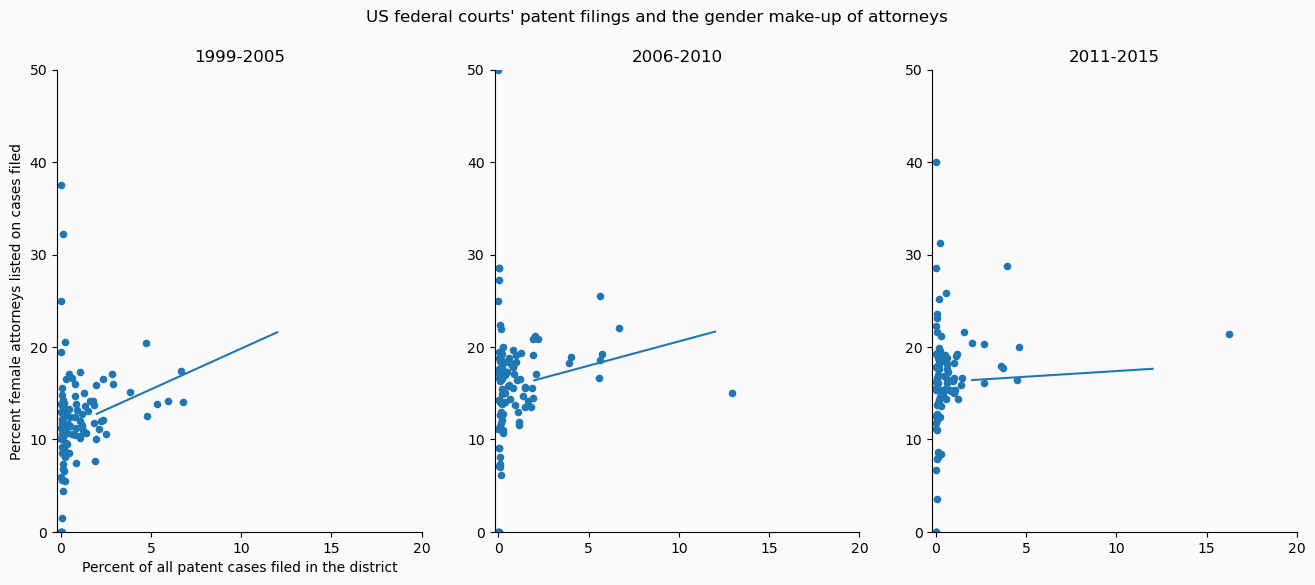

In [188]:
def single_scatter_plot(df, year, ax):
    """
    This function creates a single year's percent filings to percent female plot
    """
    # Filter data to keep only the data of interest
    _df = df_court[df_court['year_range'] == year]
    _df.plot(
        kind="scatter", x="percent_filings", y="percent_female", ax=ax
    )

    lr = LinearRegression()
    X = _df["percent_filings"].values.reshape(-1, 1)# you can feed -1 as one of the values in reshape and 
                                                # let numpy figure out that dimension
    y = _df["percent_female"].values.reshape(-1, 1) # the output is an array
    lr.fit(X, y)

    x = np.linspace(2.0, 12.0).reshape(-1, 1)
    y_pred = lr.predict(x)
    ax.plot(x, y_pred)

    return ax

# Create initial plot
fig, ax = plt.subplots(1, 3, figsize=(16, 6))

for (i, year) in enumerate(df_court.year_range.unique()):
    single_scatter_plot(df, year, ax[i])
    ax[i].set_title(str(year))

bgcolor = (250/255, 250/255, 250/255)
fig.set_facecolor(bgcolor)
for (i, _ax) in enumerate(ax):
    # Label with words
    if i == 0:
        _ax.set_xlabel("Percent of all patent cases filed in the district")
    else:
        _ax.set_xlabel("")

    # Turn off right and top axis lines
    _ax.spines['right'].set_visible(False)
    _ax.spines['top'].set_visible(False)

    # Don't use such a white background color
    _ax.set_facecolor(bgcolor)

    # Change bounds
    _ax.set_ylim((0, 50))
    _ax.set_xlim((-0.2, 20))
 
    # Change ticks
    # xticks = [10, 100, 1000, 10000]
    # _ax.set_xticks([np.log(xi) for xi in xticks])
    # _ax.set_xticklabels([str(xi) for xi in xticks])

    # yticks = list(range(5, 32, 5))
    # _ax.set_yticks([np.log(yi) for yi in yticks])
    if i == 0:
        # _ax.set_yticklabels([str(yi) for yi in yticks])
        _ax.set_ylabel("Percent female attorneys listed on cases filed")
    else:
        # _ax.set_yticklabels([])
        _ax.set_ylabel("")

ax[0].set_zorder(1)
fig.suptitle("US federal courts' patent filings and the gender make-up of attorneys")

In [416]:
# percent filings in top 10 courts by year

df_top = df.drop(["date_filed", "date_closed", "date_last_filed"], axis=1)
df_top = df_top.groupby(["court_state", "court_region", "year_filed"]).agg("sum")
df_top = df_top.reset_index()
df_top = df_top.drop(df_top.iloc[:, 3:22], axis=1)

# create variable showing proportion of case filings made in year range in a given court
for year in range(1999, 2016):
    df_top.loc[df_top["year_filed"] == year, "total_filings"] = df_top[df_top["year_filed"] == year]["post_99"].sum(axis=0)

# create new dataset with top 10 courts, bottom 10 courts
df_top_years = df_top[df_top["year_filed"] == 1999].nlargest(10, "post_99")
for year in range(2000, 2016):
    _df = df_top[df_top["year_filed"] == year].nlargest(10, "post_99")
    df_top_years = pd.concat([df_top_years, _df], axis = 0)
df_top_years["top10"] = 1

for year in range(1999, 2016):
    _df = df_top[df_top["year_filed"] == year].nsmallest(84, "post_99")
    df_top_years = pd.concat([df_top_years, _df], axis = 0)
df_top_years = df_top_years.fillna(0)

df_top_years = df_top_years.drop(df_top_years.iloc[:, 4:23], axis=1)
df_top_years = df_top_years.drop(df_top_years.iloc[:, 0:2], axis=1)
df_top_years["year_filed"] = df_top_years["year_filed"].astype(int)
df_top_years = df_top_years.groupby(["top10", "year_filed"]).agg({"post_99":"sum", "total_filings": "max"})

df_top_years["percent_filings"] = 100* df_top_years["post_99"] / df_top_years["total_filings"]

# df_top_years

Text(0.5, 1.0, 'Patent cases filed in most filed in US district circuits, 1999-2015')

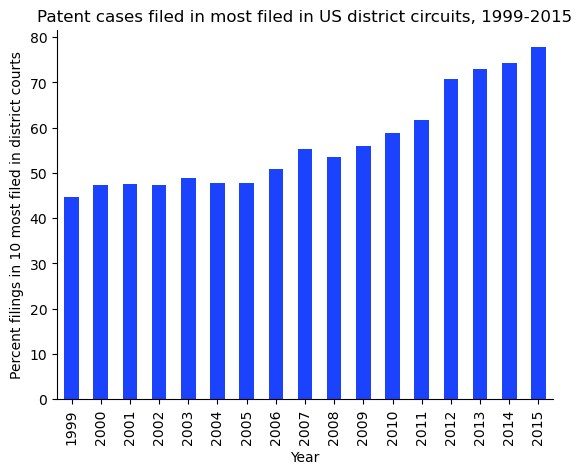

In [418]:
df_top_years = df_top_years.drop(["post_99", "total_filings"], axis=1)
df_top_years = df_top_years.reset_index(level = "top10")
df_top_years = df_top_years[df_top_years["top10"] == 1]
df_top_years = df_top_years.drop("top10", axis=1)

fig, ax = plt.subplots()

df_top_years["percent_filings"].plot(kind="bar", ax=ax, color="#1b42fc")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel("Year")
ax.set_ylabel("Percent filings in 10 most filed in district courts")
ax.set_title("Patent cases filed in most filed in US district circuits, 1999-2015")

<Axes: xlabel='percent_filings'>

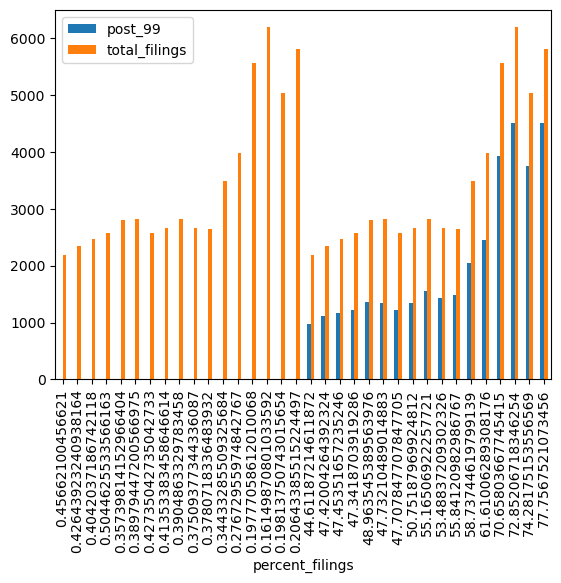

In [316]:
x = 
y1 = np.array([10, 20, 10, 30])
y2 = np.array([20, 25, 15, 25])
 
# plot bars in stack manner
plt.bar(x, y1, color='r')
plt.bar(x, y2, bottom=y1, color='b')
plt.xlabel("Teams")
plt.ylabel("Score")
plt.title("Scores by Teams in 4 Rounds")
plt.show()